In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ptitprince as pt
from matplotlib import patches
from matplotlib import lines
from typing import List, Tuple, Dict, Callable

# disable warnings>
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

In [2]:
# # Compute avg similarity for each base sample
# similarities_avg_individual = {k: {} for k in labels}
# for label, dict_with_similarities in data.items():
#     for text in dict_with_similarities:
#         list_similarities = [x[0] for x in dict_with_similarities[text]]
#         similarities_avg_individual[label][text] = sum(list_similarities) / len(
#             list_similarities
#         )

# # Compute avg similarity for each label
# similarities_avg_label = {k: [] for k in labels}
# similarities_list_label = {k: [] for k in labels}
# for label, dict_with_similarities in similarities_avg_individual.items():
#     for text, similarity in dict_with_similarities.items():
#         similarities_avg_label[label].append(similarity)
#         similarities_list_label[label].append(similarity)

#     similarities_avg_label[label] = sum(similarities_avg_label[label]) / len(
#         similarities_avg_label[label]
#     )

# Boxplot with all similarities for all files

# Ten-dim

In [3]:
files = [file for file in os.listdir() if file.startswith('ten-dim') and file.endswith('.json')]
labels: List[str] = [
            "social_support",
            "conflict",
            "trust",
            "neutral",
            "fun",
            "respect",
            "knowledge",
            "power",
            "similarity_identity",
        ]

df_list = []

for filename in files:
    data = pd.read_json(filename, orient='records')
    name = "_".join( filename.split('_')[1:3])
    data['dataset'] = name
    data['label'] = data.target.apply(lambda x: labels[x])
    data.rename(columns = {'pairwise_sim': 'inter-similarity', "within_sim" : 'intra-similarity', 
    "augment_sbleu_group" : 'self_bleu_group', "augment_sbleu" : 'self_bleu'}, inplace = True)
    df_list.append(data)

df = pd.concat(df_list)
df = df[df.self_bleu_group > -1]

#parse the classifcation reports in the folder classification_results, the files are csv files
classification_reports = []
for filename in os.listdir('./classification_results'):
    if filename.endswith('.csv'):
        cl = pd.read_csv(os.path.join('./classification_results', filename))
        cl['dataset'] = ".".join(filename.split('.')[:-1])
        #convert label columns to long format
        cl = pd.melt(cl[labels + [ 'metric', 'dataset']], id_vars=[ 'metric', 'dataset'], value_vars=labels, var_name='label', value_name='score')

        #convert metric column to wide format
        
        classification_reports.append(cl)

metrics_df = pd.concat(classification_reports)
metrics_df = metrics_df.pivot(index=['dataset', 'label'], columns='metric', values='score')



In [7]:
def get_middle_value(data):
    return data.iloc[int(len(data)/2)]

#group df by dataset and label, then show the rows with the 10 highest similarity
df_grouped_low = df.groupby(['dataset', 'label']).apply(lambda x: x.nsmallest(1, 'inter-similarity')).reset_index(drop=True)
df_grouped_low['type'] = 'low'

df_grouped_high = df.groupby(['dataset', 'label']).apply(lambda x: x.nlargest(1, 'inter-similarity')).reset_index(drop=True)
df_grouped_high['type'] = 'high'

df_grouped_med = df.groupby(['dataset', 'label']).apply(lambda x: get_middle_value(x.sort_values('inter-similarity'))).reset_index(drop=True)
df_grouped_med['type'] = 'med'

# inner join all three dataframes
df_grouped = pd.merge(df_grouped_low, df_grouped_high, on=['dataset', 'label'], suffixes=('_low', '_high'))
df_grouped = pd.merge(df_grouped, df_grouped_med, on=['dataset', 'label'], suffixes=('', '_med'))

In [10]:
#concatenate all three dataframes
df_grouped_concat = pd.concat([df_grouped_low, df_grouped_high, df_grouped_med])
#filter for datasets including balanced 
df_grouped_concat = df_grouped_concat[df_grouped_concat.dataset.str.contains('balanced')]

df_grouped_concat = df_grouped_concat[['label', 'type', 'dataset', 'h_text', 'augmented_h_text']].reset_index(drop=True)
pd.set_option('display.max_colwidth', None)


#sort be label, type and dataset
df_grouped_concat = df_grouped_concat.sort_values(['label', 'type', 'dataset']).reset_index(drop=True)
#rename values in dataset column
df_grouped_concat.dataset = df_grouped_concat.dataset.apply(lambda x: x.replace('balanced_gpt-3.5-turbo', 'ChatGPT').replace('balanced_gpt-4', 'GPT-4'))
#rename values in type column
df_grouped_concat.type = df_grouped_concat.type.apply(lambda x: x.replace('low', 'Low').replace('high', 'High').replace('med', 'Medium'))
#rename values in label column
df_grouped_concat.label = df_grouped_concat.label.apply(lambda x: x.replace('social_support', 'Social Support').replace('conflict', 'Conflict').replace('trust', 'Trust').replace('neutral', 'Neutral').replace('fun', 'Fun').replace('respect', 'Respect').replace('knowledge', 'Knowledge').replace('power', 'Power').replace('similarity_identity', 'Similarity/Identity'))
#rename h_text column to Base
df_grouped_concat.rename(columns={'h_text': 'Base'}, inplace=True)
#rename augmented_h_text column to Augmented
df_grouped_concat.rename(columns={'augmented_h_text': 'Augmented'}, inplace=True)
#capital column names
df_grouped_concat.columns = df_grouped_concat.columns.str.capitalize()
#rename type column to Similarity
df_grouped_concat.rename(columns={'Type': 'Similarity'}, inplace=True)

print(df_grouped_concat.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
              Label & Similarity & Dataset &                                                                                                              Base &                                                                                                                                              Augmented \\
\midrule
           Conflict &       High & ChatGPT &                    I'm not so sure why you think that after 19 weeks of fitnessing you should be coaching anyone. &                                                  I don't think it's fair to put yourself in a position to coach others after only 19 weeks of fitness. \\
           Conflict &       High &   GPT-4 &  To equate the two demonstrates you maybe don't fully understand the reasons for Russia meddling in our politics. & It appears you don't entirely understand the reasons for Russia's interference in our politics if you're drawing parallels between the two situations. \\
           Con

In [90]:
print(df.groupby([ 'dataset']).agg({'self_bleu_group': ['mean', 'std'],
                                      'inter-similarity': ['mean', 'std'],
                                      'intra-similarity': ['mean', 'std'],
                                        'self_bleu': ['mean', 'std']}
                                      ).round(3).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{self\_bleu\_group} & \multicolumn{2}{l}{inter-similarity} & \multicolumn{2}{l}{intra-similarity} & \multicolumn{2}{l}{self\_bleu} \\
{} &            mean &    std &             mean &    std &             mean &    std &      mean &    std \\
dataset                    &                 &        &                  &        &                  &        &           &        \\
\midrule
balanced\_gpt-3.5-turbo     &           0.023 &  0.040 &            0.794 &  0.055 &            0.842 &  0.038 &     0.003 &  0.026 \\
balanced\_gpt-4             &           0.037 &  0.050 &            0.880 &  0.040 &            0.887 &  0.032 &     0.017 &  0.060 \\
proportional\_gpt-3.5-turbo &           0.090 &  0.110 &            0.798 &  0.060 &            0.869 &  0.040 &     0.006 &  0.038 \\
proportional\_gpt-4         &           0.100 &  0.096 &            0.892 &  0.039 &            0.911 &  0.028 &     0.038 &  0.089 \\
\bottomrule
\e

In [91]:
mean_data = df.groupby(['label', 'dataset']).agg({'self_bleu_group': ['mean', 'std'],
                                      'inter-similarity': ['mean', 'std'],
                                      'intra-similarity': ['mean', 'std'],
                                        'self_bleu': ['mean', 'std']}
                                      )
#reset columns
mean_data.columns = mean_data.columns.map('_'.join).str.strip('_')
mean_data.reset_index(inplace=True)

mean_data = mean_data.merge(metrics_df, on=['dataset', 'label'], how='left')


# Inter-similarity vs Intra-similarity

In [ ]:
#4 subplots one for each dataset in mean_data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, (dataset, data) in enumerate(mean_data.groupby('dataset')):
    ax = axes[i//2, i%2]
    sns.scatterplot(data=data, x='inter-similarity_mean', y='intra-similarity_mean', hue='label', ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel('inter-similarity')
    ax.set_ylabel('intra-similarity')
        #make only a single legend
    if i == 0:
        axes[i//2, i%2].legend()
    else:
        axes[i//2, i%2].get_legend().remove()
    #same scale for all plots
    axes[i//2, i%2].set_xlim(0.77, 0.94)
    axes[i//2, i%2].set_ylim(0.8, 0.94)


# Intra Self-BLEU vs Intra similarity

In [ ]:
#4 subplots one for each dataset in mean_data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, (dataset, data) in enumerate(mean_data.groupby('dataset')):
    ax = axes[i//2, i%2]
    sns.scatterplot(data=data, x='self_bleu_group_mean', y='intra-similarity_mean', hue='label', ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel('intra-Self BLEU')
    ax.set_ylabel('intra-similarity')
        #make only a single legend
    if i == 0:
        axes[i//2, i%2].legend()
    else:
        axes[i//2, i%2].get_legend().remove()
    #same scale for all plots
    axes[i//2, i%2].set_xlim(0, 0.25)
    axes[i//2, i%2].set_ylim(0.75, 0.94)

# Inter similarity

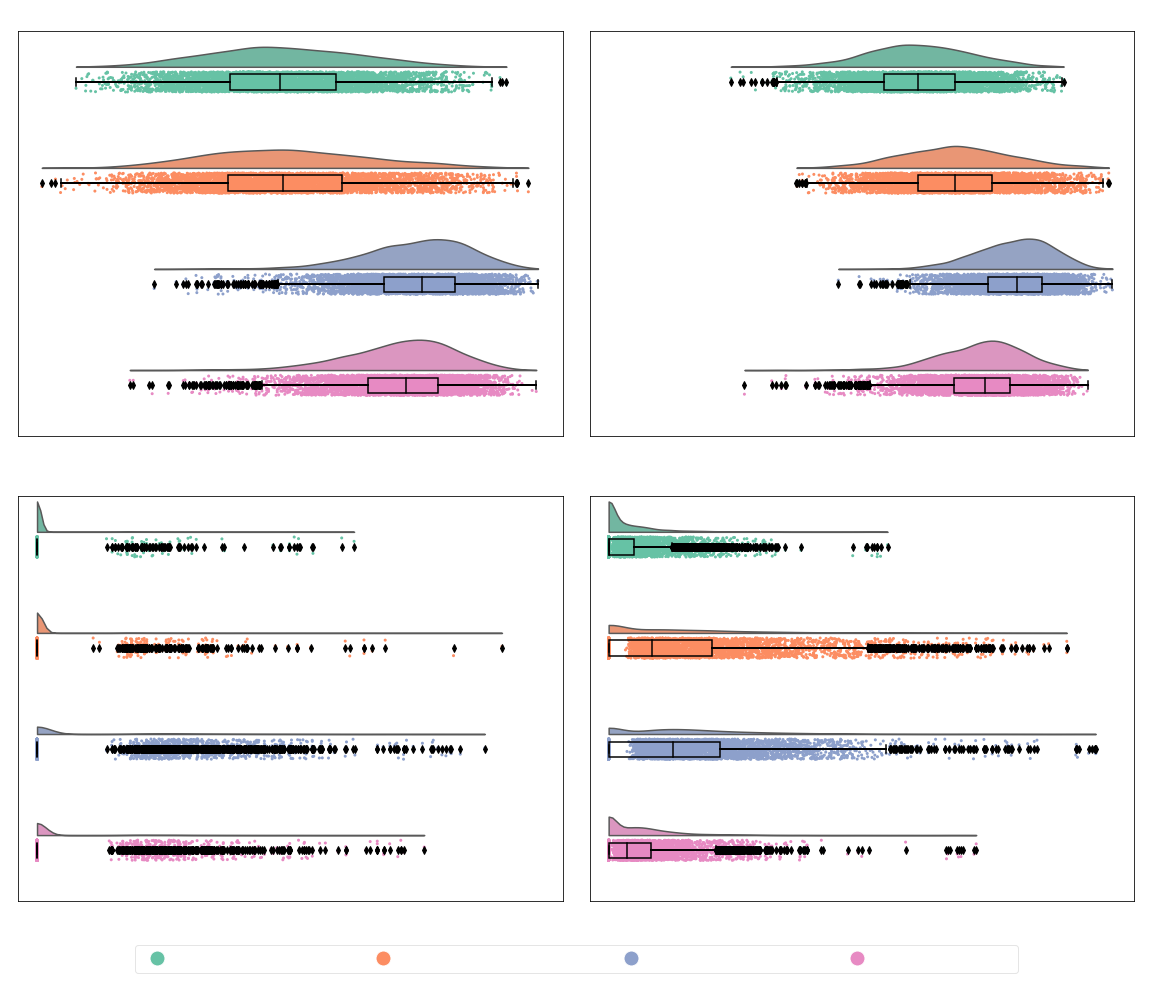

In [22]:
pal = 'Set2'
ort = 'h'

metrics = ["inter-similarity", "intra-similarity", 'self_bleu', "self_bleu_group"]
models_list = ["ChatGPT Balanced",'ChatGPT Proportional', 'GPT-4 Proportional', 'GPT-4 Balanced']
colors = sns.color_palette(pal, len(models_list))

f, axes = plt.subplots(2, 2, figsize=(20, 15))

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    pt.half_violinplot( x=metric, y="dataset", data = df, palette = pal, bw = .2, cut = 0.,
    scale = "area", width = .6, inner = None, orient = ort, ax=ax)

    ax=sns.stripplot(x=metric, y="dataset", data = df, palette = pal, edgecolor = "white",
    size = 3, jitter = 1, zorder = 0, orient = ort, ax=ax)

    ax=sns.boxplot( x=metric, y="dataset", data = df, color = "black", width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
    showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
    saturation = 1, orient = ort, ax=ax)
    if 'similarity' in metric:
        ax.set_xlim(0.6, 1)
    ax.set_xlabel(metric)
    if 'bleu' in metric:
        ax.set_xlim(-0.025, 0.7)

    ax.set_yticklabels([])
    ax.set_yticks([])
    #set x axis label color to white
    ax.tick_params(axis='x', colors='white')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
    #set transparent background
    ax.patch.set_alpha(0.5)

#make a legend of models_list with white label text
legend_elements = [lines.Line2D([0], [0], marker='o', color='w', label=model, markerfacecolor=color, markersize=15) for model, color in zip(models_list, colors)]

#place legend centered below the plots
leg = f.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=16, framealpha=0.5)
for text in leg.get_texts():
    text.set_color("white")

#reduce distance between legend and plots
plt.subplots_adjust(bottom=0.075)

axes[0][0].set_xlabel("Cosine similarity", fontsize=16, color='w')
axes[0][0].set_title('Inter-similarity', fontsize=24, color='w')
axes[1][0].set_xlabel("BLEU", fontsize=16, color='w')
#axes[1][0].set_title('Intra-similarity', fontsize=20)
axes[0][1].set_title('Intra-similarity', fontsize=24, color='w')
axes[0][1].set_xlabel("Average cosine similarity", fontsize=16, color='w')
#axes[1][1].set_title('Self-BLEU', fontsize=20)
axes[1][1].set_xlabel("Average BLEU", fontsize=16, color='w')


#remove distance between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.15)

#plt.savefig('similarity_boxplots.png', dpi = 300)

In [150]:
df.groupby('dataset').quantile(0.95)['self_bleu']

dataset
balanced_gpt-3.5-turbo        0.000000
balanced_gpt-4                0.165010
proportional_gpt-3.5-turbo    0.000000
proportional_gpt-4            0.239781
Name: self_bleu, dtype: float64

## TSNE of Crowdsourced data

In [140]:
#read ten dim features tsv file as numpy
ten_dim_features = np.loadtxt('ten-dim_features_no_neutral.tsv', delimiter='\t')


sne = TSNE(n_components=2, perplexity=50, learning_rate=50, n_iter=20000, n_jobs=-1)
print(sne.learning_rate)
X_new = sne.fit_transform(ten_dim_features)
print(sne.n_iter_)
print(sne.learning_rate)

50
11799
50


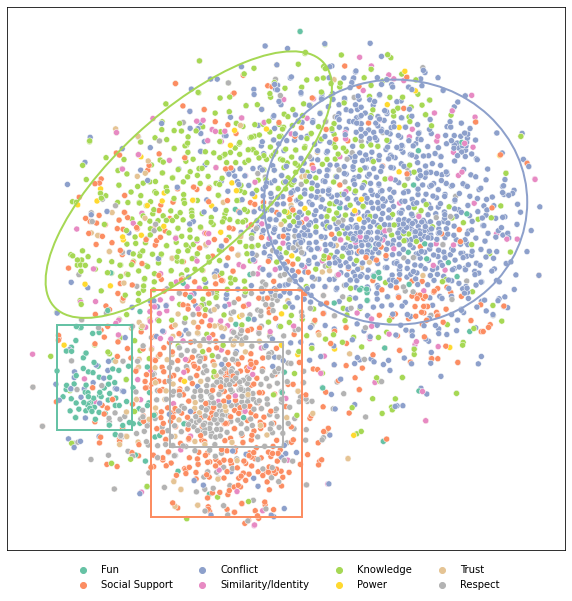

In [244]:
# seaborn scatterplot
fig, ax = plt.subplots( figsize=(10, 10))

colors = sns.color_palette('Set2', n_colors=8)
color_label = ['Fun', 'Social Support', 'Conflict', 'Similarity/Identity', 'Knowledge', 'Power', 'Trust', 'Respect']
colors_dict = dict(zip(color_label, colors))

labs = np.loadtxt('ten-dim_labels_no_neutral.tsv', delimiter='\t', dtype=str)
sns.scatterplot(x=X_new[:,0], y=X_new[:,1], hue=labs[:,1], palette='Set2', legend='full', ax=ax)

#rename legend labels to color_label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, color_label, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)
#remove box around legend
ax.get_legend().get_frame().set_linewidth(0.0)

#create box from (-60,-45) to (-40,-15)
rect = patches.Rectangle((-60,-45),20,30,linewidth=2,edgecolor=colors_dict['Fun'],facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
#create box from (-35,-70) to (5,-5)
rect = patches.Rectangle((-35,-70),40,65,linewidth=2,edgecolor=colors_dict['Social Support'],facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
#create box from (-30,-50) to (0,-20)
rect = patches.Rectangle((-30,-50),30,30,linewidth=2,edgecolor=colors_dict['Respect'],facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
#create elipse with center (-20,20) and width 40 and height 80, rotated 45 degrees
ellipse = patches.Ellipse((-25,25),40,100,linewidth=2,edgecolor=colors_dict['Knowledge'],facecolor='none', angle=-45)
# Add the patch to the Axes
ax.add_patch(ellipse)
#create circle with center (25,25) and radius 20
circle = patches.Circle((30,20),35,linewidth=2,edgecolor=colors_dict['Conflict'],facecolor='none')
# Add the patch to the Axes
ax.add_patch(circle)

ax.tick_params(axis=u'both', which=u'both',length=0)
#remove ticklabels
ax.set_xticklabels([])
ax.set_yticklabels([])

#save plot with high dpi

plt.savefig('tsne_clust.png', dpi = 600)


In [23]:
#read ten dim features tsv file as numpy
ten_dim_features = np.loadtxt('ten-dim_features.tsv', delimiter='\t')


sne = TSNE(n_components=2, perplexity=50, learning_rate=50, n_iter=30000, n_jobs=-1)
print(sne.learning_rate)
X_new = sne.fit_transform(ten_dim_features)
print(sne.n_iter_)
print(sne.learning_rate)

50
20949
50


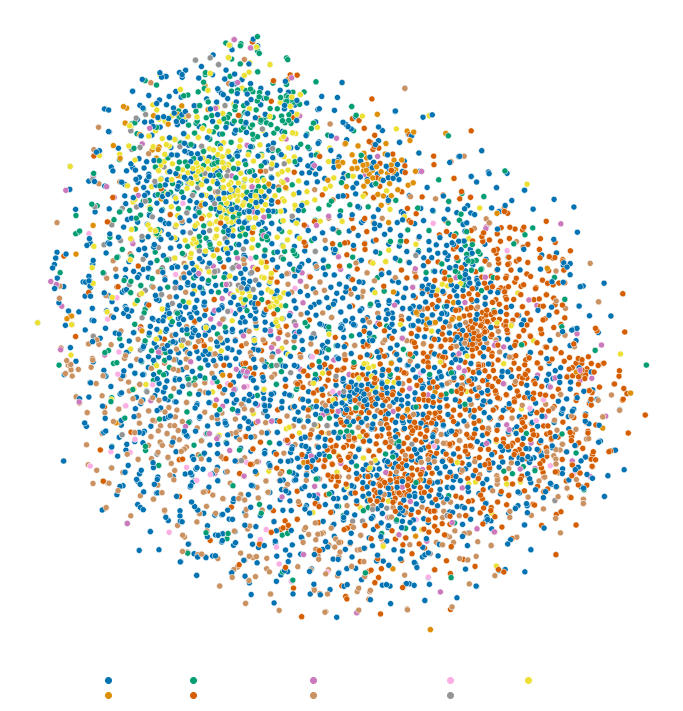

In [49]:
# seaborn scatterplot
fig, ax = plt.subplots( figsize=(12, 12))
color_label = ['Neutral', 'Fun', 'Social Support', 'Conflict', 'Similarity/Identity', 'Knowledge', 'Power', 'Trust', 'Respect']


labs = np.loadtxt('ten-dim_labels.tsv', delimiter='\t', dtype=str)
sns.scatterplot(x=X_new[:,0], y=X_new[:,1], hue=labs[:,1], palette='colorblind', legend='full', ax=ax)
#rename legend labels to color_label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, color_label, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5, framealpha=0.0)
#remove box around legend
ax.get_legend().get_frame().set_linewidth(0.0)
for text in ax.get_legend().get_texts():
    text.set_color("white")

ax.tick_params(axis=u'both', which=u'both',length=0)
#remove ticklabels
ax.set_xticklabels([])
ax.set_yticklabels([])
#make background transparent
ax.patch.set_alpha(0.0)
#remove borders
ax.axis('off')

plt.savefig('tsne_with_neutral_new.png', dpi = 600)

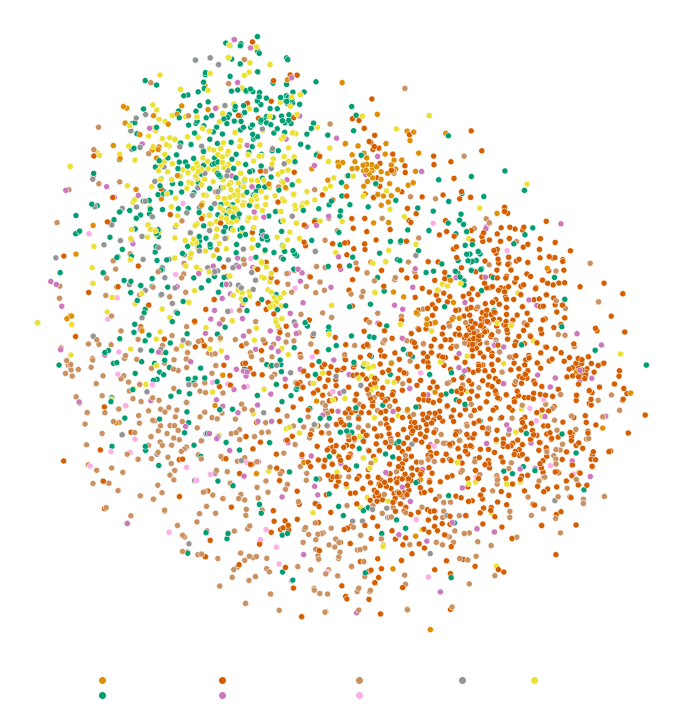

In [50]:
# seaborn scatterplot
fig, ax = plt.subplots( figsize=(12, 12))
color_label = ['Fun', 'Social Support', 'Conflict', 'Similarity/Identity', 'Knowledge', 'Power', 'Trust', 'Respect']
colors = sns.color_palette('colorblind', n_colors=9)[1:]

labs = np.loadtxt('ten-dim_labels.tsv', delimiter='\t', dtype=str)

X_no_neutral = X_new[labs[:,1] != 'neutral']
labs = labs[labs[:,1] != 'neutral']

sns.scatterplot(x=X_no_neutral[:,0], y=X_no_neutral[:,1], hue=labs[:,1], palette=colors, legend='full', ax=ax)
#rename legend labels to color_label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, color_label, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5, framealpha=0.0)
#remove box around legend
ax.get_legend().get_frame().set_linewidth(0.0)
for text in ax.get_legend().get_texts():
    text.set_color("white")

ax.tick_params(axis=u'both', which=u'both',length=0)
#remove ticklabels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.patch.set_alpha(0.0)
#remove borders
ax.axis('off')

plt.savefig('tsne_no_neutral.png', dpi = 600)

In [130]:
#read ten dim features tsv file as numpy
ten_dim_features = np.loadtxt('ten-dim_features.tsv', delimiter='\t')
sne = TSNE(n_components=2, perplexity=30, learning_rate=50, n_iter=20000, n_jobs=-1)
print(sne.learning_rate)
X_30 = sne.fit_transform(ten_dim_features)
print(sne.n_iter_)
print(sne.learning_rate)

50
15299
50


<AxesSubplot:>

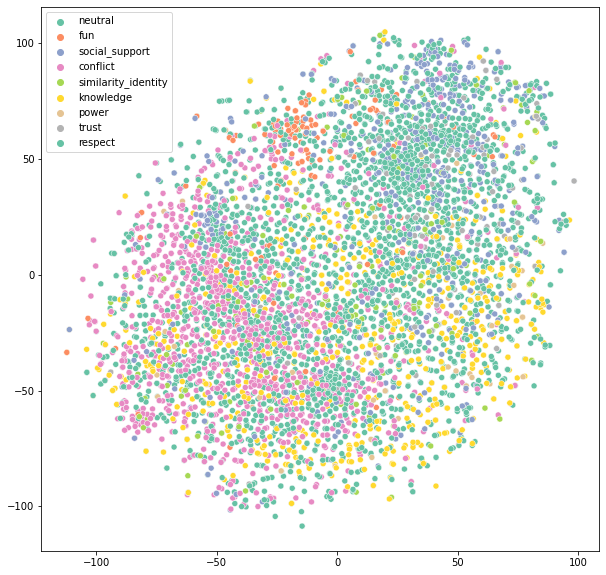

In [131]:
# seaborn scatterplot
fig, ax = plt.subplots( figsize=(10, 10))

labs = np.loadtxt('ten-dim_labels.tsv', delimiter='\t', dtype=str)
sns.scatterplot(x=X_30[:,0], y=X_30[:,1], hue=labs[:,1], palette='Set2', legend='full', ax=ax)

## TSNE of ChatGPT balanced data

In [4]:
#read ten dim features tsv file as numpy
ten_dim_features = np.loadtxt('ten-dim_augmented_features.tsv', delimiter='\t')


sne = TSNE(n_components=2, perplexity=50, learning_rate=50, n_iter=30000, n_jobs=-1)
print(sne.learning_rate)
X_new = sne.fit_transform(ten_dim_features)
print(sne.n_iter_)
print(sne.learning_rate)

50
28399
50


In [30]:
labs[:,0]

array(['5', '6', '4', ..., '6', '4', '3'], dtype='<U19')

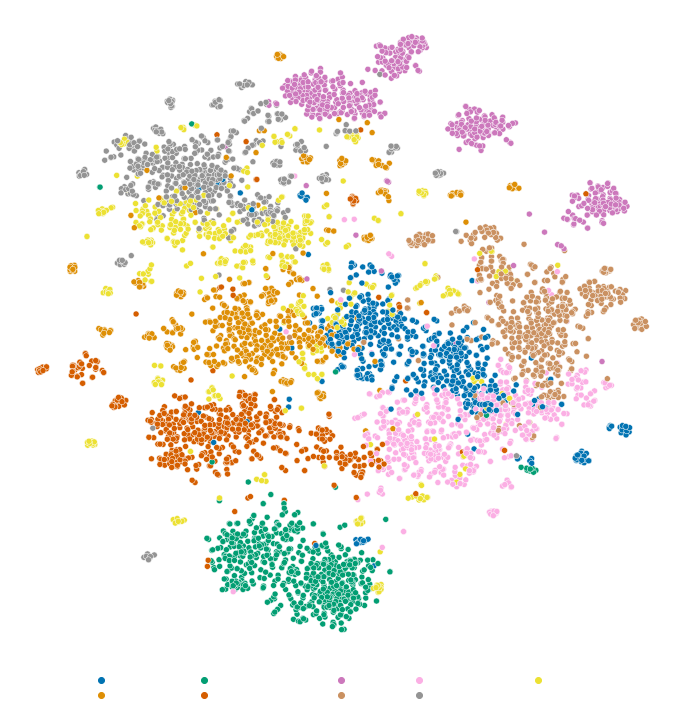

In [35]:
# seaborn scatterplot
fig, ax = plt.subplots( figsize=(12, 12))
color_label = ['Respect', 'Knowledge', 'Fun', 'Similarity/Identity', 'Power', 'Trust','Social Support', 'Conflict', 'Neutral']
labs = np.loadtxt('ten-dim_augmented_labels.tsv', delimiter='\t', dtype=str)
sns.scatterplot(x=X_new[:,0], y=X_new[:,1], hue=labs[:,1], palette='colorblind', legend='full', ax=ax)
#rename legend labels to color_label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, color_label, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5, framealpha=0.0)
#remove box around legend
ax.get_legend().get_frame().set_linewidth(0.0)
for text in ax.get_legend().get_texts():
    text.set_color("white")

ax.tick_params(axis=u'both', which=u'both',length=0)
#remove ticklabels
ax.set_xticklabels([])
ax.set_yticklabels([])
#make background transparent
ax.patch.set_alpha(0.0)
#remove borders
ax.axis('off')

plt.savefig('tsne_augmented_with_neutral_new.png', dpi = 600)

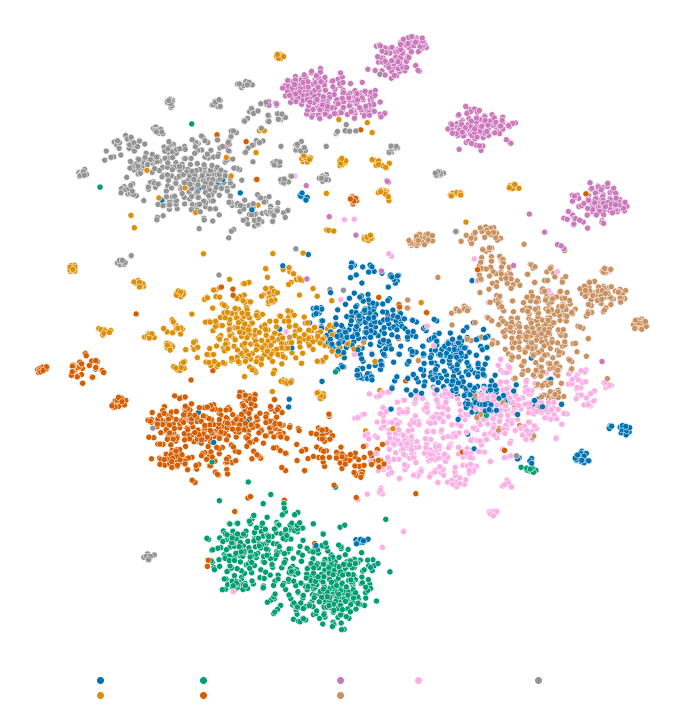

In [36]:
# seaborn scatterplot
fig, ax = plt.subplots( figsize=(12, 12))
color_label = ['Respect', 'Knowledge', 'Fun', 'Similarity/Identity', 'Power', 'Trust','Social Support', 'Conflict']
#colors = sns.color_palette('colorblind', n_colors=10)[2:]

labs = np.loadtxt('ten-dim_augmented_labels.tsv', delimiter='\t', dtype=str)

X_no_neutral = X_new[labs[:,1] != 'neutral']
labs = labs[labs[:,1] != 'neutral']

sns.scatterplot(x=X_no_neutral[:,0], y=X_no_neutral[:,1], hue=labs[:,1], palette='colorblind', legend='full', ax=ax)
#rename legend labels to color_label
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, color_label, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5, framealpha=0.0)
#remove box around legend
ax.get_legend().get_frame().set_linewidth(0.0)
for text in ax.get_legend().get_texts():
    text.set_color("white")

ax.tick_params(axis=u'both', which=u'both',length=0)
#remove ticklabels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.patch.set_alpha(0.0)
#remove borders
ax.axis('off')

plt.savefig('tsne_augmented_no_neutral.png', dpi = 600)

# Confusion matrices




# Confusion matrices




#### Crowdsourced Normal vs SetFit

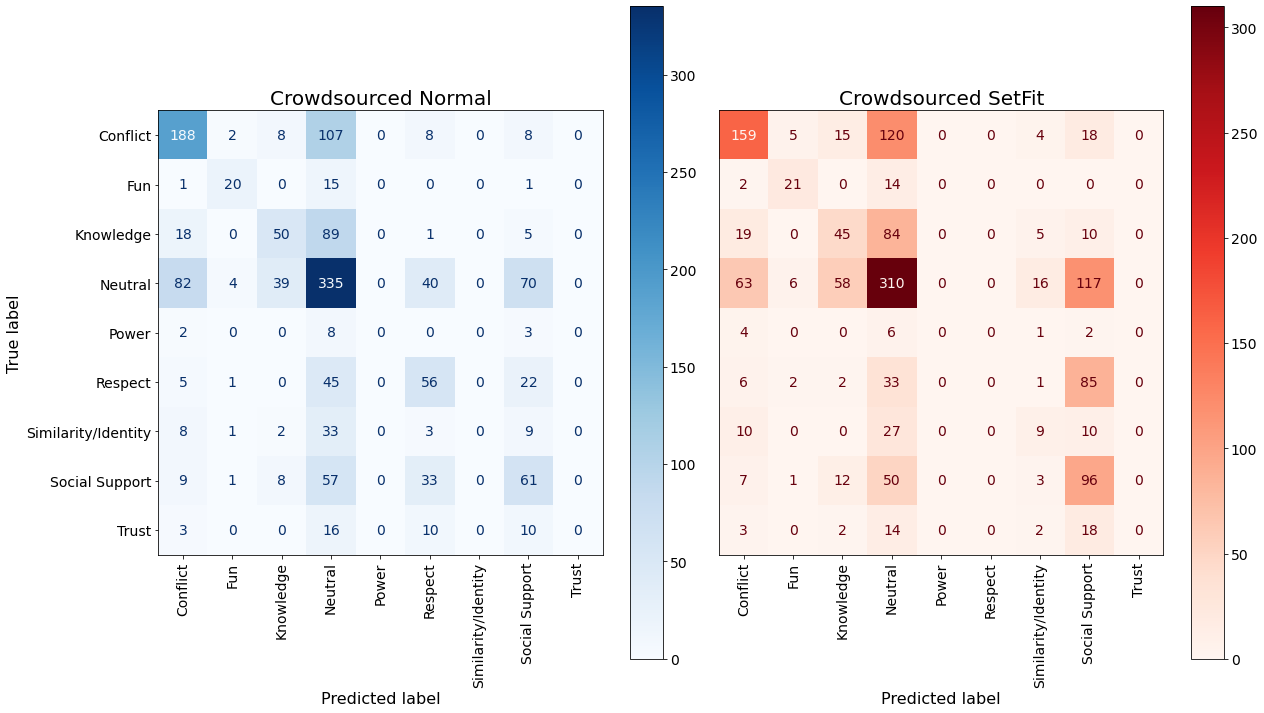

In [4]:
plot_labels = ['Conflict', 'Fun', 'Knowledge', 'Neutral', 'Power', 'Respect', 'Similarity/Identity', 'Social Support', 'Trust' ]

plt.rcParams.update({'font.size': 14})


df_list = []
for filename in os.listdir():
    if "crowdsourced" in filename:
    #if 'gpt-3' in filename and "e5" in filename:
        data = pd.read_json( filename, orient='records')
        data['dataset'] = ".".join(filename.split('.')[:-1])
        df_list.append(data)

#plot 2 subplots:
fig, axs = plt.subplots(1, 2, figsize=(20, 12))

for i, df in enumerate(df_list):
    if i == 0:
        cmap = 'Blues'
        axs[i].set_title('Crowdsourced Normal', fontsize=20)
    else:
        cmap = 'Reds'
        axs[i].set_title('Crowdsourced SetFit', fontsize=20)
        
    ConfusionMatrixDisplay.from_predictions(df.targets_labels, df.preds_labels, cmap=cmap,
        xticks_rotation='vertical', ax=axs[i],  colorbar=True, normalize=None)
    
    axs[i].set_xticklabels(plot_labels, fontsize=14)
    axs[i].set_xlabel('Predicted label', fontsize=16)
    if i ==1:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
        
axs[0].set_yticklabels(plot_labels, fontsize=14)
axs[0].set_ylabel('True label', fontsize=16)

fig.subplots_adjust(wspace=0.01, hspace=0)

#plt.rcParams.update({'font.size': 10})

plt.savefig('classification_results/conf_mat_crowd.png', dpi = 300)

#### ChatGPT balanced Setfit vs ChatGPT balanced + Crowdsourced Normal

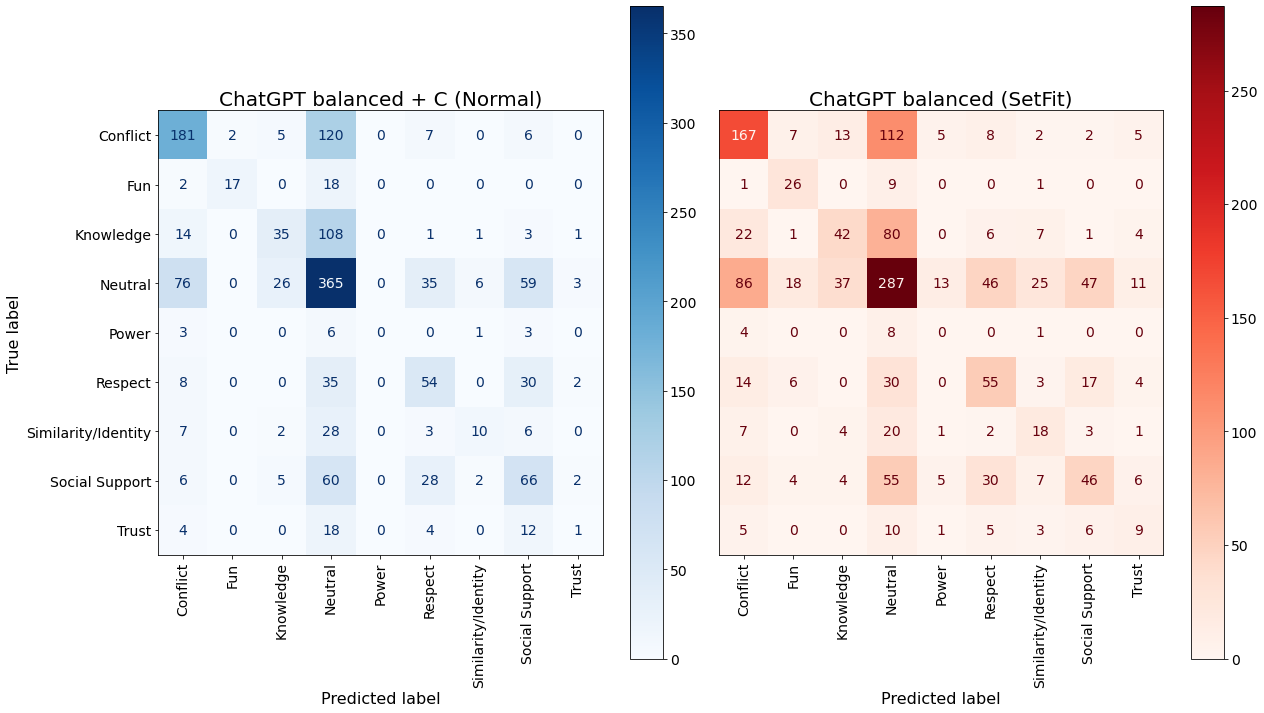

In [5]:
df_list = []
for filename in os.listdir():
    if 'gpt-3' in filename and "e5" in filename:
        data = pd.read_json( filename, orient='records')
        data['dataset'] = ".".join(filename.split('.')[:-1])
        df_list.append(data)

#plot 2 subplots:
fig, axs = plt.subplots(1, 2, figsize=(20, 12))


for i, df in enumerate(df_list):
    if i == 0:
        cmap = 'Blues'
        axs[i].set_title('ChatGPT balanced + C (Normal)', fontsize=20)
    else:
        cmap = 'Reds'
        axs[i].set_title('ChatGPT balanced (SetFit)', fontsize=20)
        
    ConfusionMatrixDisplay.from_predictions(df.targets_labels, df.preds_labels, cmap=cmap,
        xticks_rotation='vertical', ax=axs[i],  colorbar=True, normalize=None)
    axs[i].set_xticklabels(plot_labels, fontsize=14)
    axs[i].set_xlabel('Predicted label', fontsize=16)
    if i ==1:
        axs[i].set_ylabel('')
        axs[i].set_yticks([])
        
axs[0].set_yticklabels(plot_labels, fontsize=14)
axs[0].set_ylabel('True label', fontsize=16)

fig.subplots_adjust(wspace=0.01, hspace=0)

plt.savefig('classification_results/conf_mat_chatGPT.png', dpi = 300)

## Sentiment

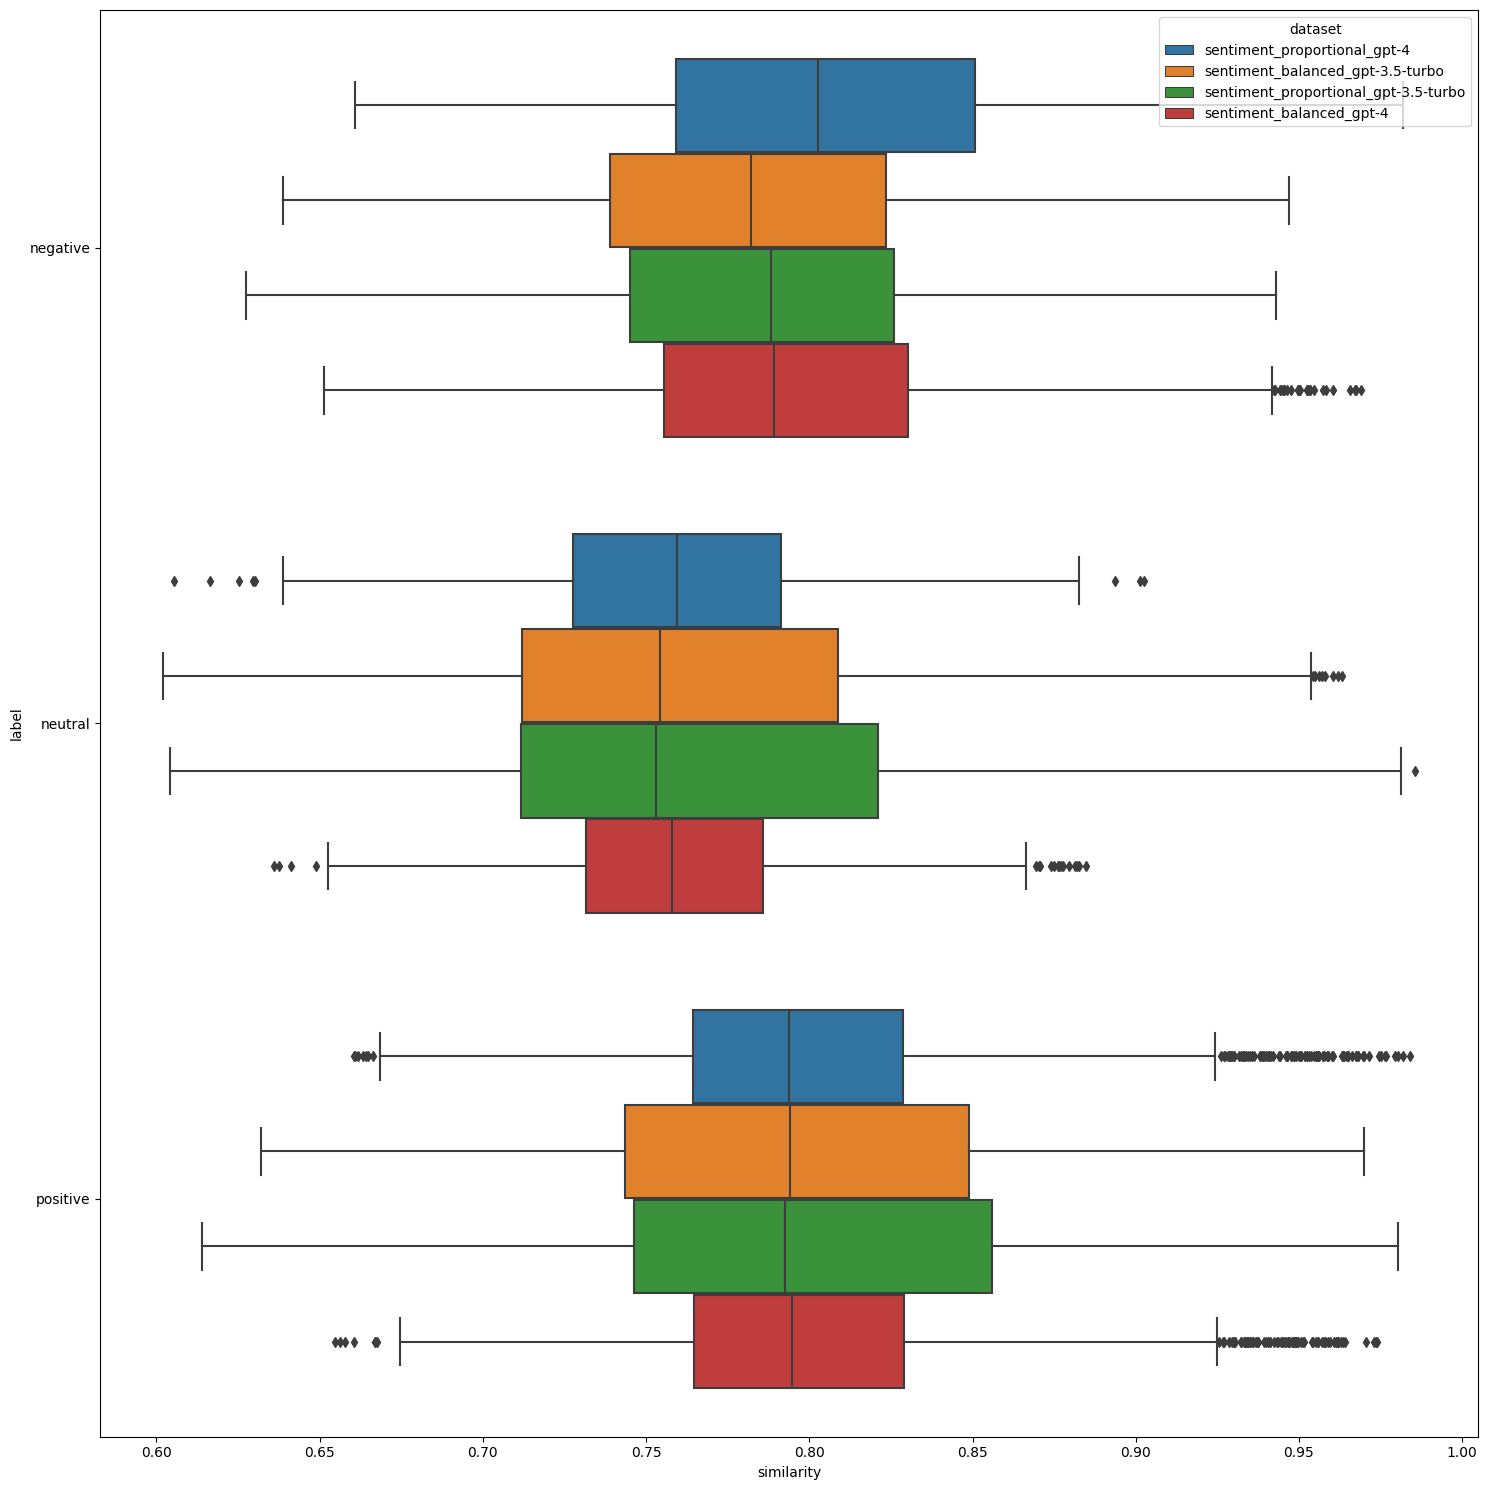

In [6]:
files = [file for file in os.listdir() if file.startswith('sentiment')]
labels: List[str] = [
            "negative",
            "neutral",
            "positive",
        ]

df = pd.DataFrame(columns=["label", "similarity", "dataset"])

for filename in files:
    with open(filename) as f:
        data = json.load(f)

    similarities_concatenated = {k: [] for k in labels}
    for label, dict_with_similarities in data.items():
        for text in dict_with_similarities:
            list_similarities = [x[0] for x in dict_with_similarities[text]]
            similarities_concatenated[label].extend(list_similarities)

    for label, similarities in similarities_concatenated.items():
        df = df.append(pd.DataFrame({"label": [label] * len(similarities), "similarity": similarities, "dataset": [filename.split('_augmented_similarity.json')[0]] * len(similarities)}))

# set figure size
plt.figure(figsize=(15, 15))

sns.boxplot(data=df, x="similarity", y="label", hue="dataset")

plt.tight_layout()
plt.show()

## Hate-speech

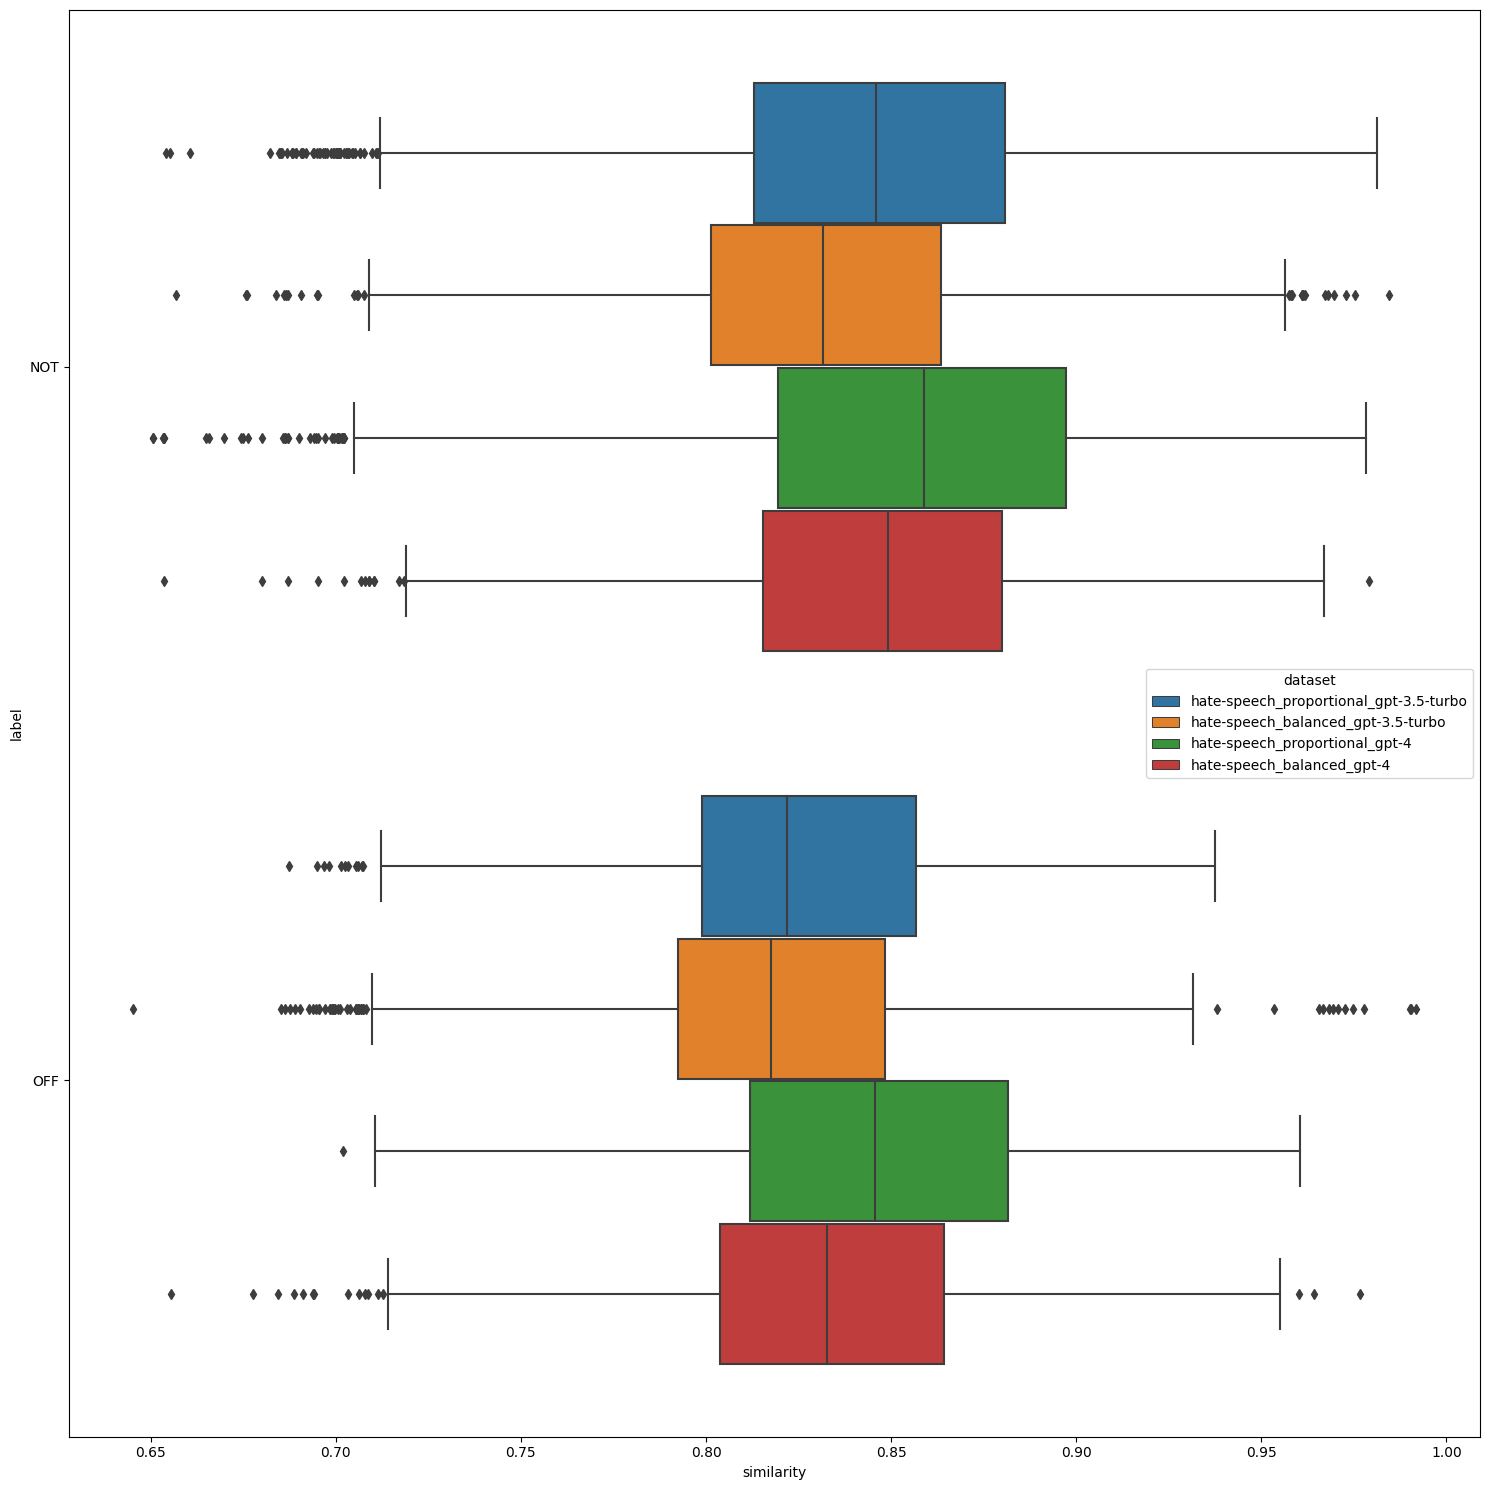

In [7]:
files = [file for file in os.listdir() if file.startswith('hate-speech')]
labels: List[str] = ["NOT", "OFF"]

df = pd.DataFrame(columns=["label", "similarity", "dataset"])

for filename in files:
    with open(filename) as f:
        data = json.load(f)

    similarities_concatenated = {k: [] for k in labels}
    for label, dict_with_similarities in data.items():
        for text in dict_with_similarities:
            list_similarities = [x[0] for x in dict_with_similarities[text]]
            similarities_concatenated[label].extend(list_similarities)

    for label, similarities in similarities_concatenated.items():
        df = df.append(pd.DataFrame({"label": [label] * len(similarities), "similarity": similarities, "dataset": [filename.split('_augmented_similarity.json')[0]] * len(similarities)}))

# set figure size
plt.figure(figsize=(15, 15))

sns.boxplot(data=df, x="similarity", y="label", hue="dataset")

plt.tight_layout()
plt.show()